In [4]:
# Torch
%load_ext autoreload
%autoreload 2
from env.pendulum import PendulumEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from torchrl.envs.utils import check_env_specs, step_mdp

env = PendulumEnv()
check_env_specs(env)
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

2024-02-25 21:03:40,336 [torchrl][INFO] check_env_specs succeeded!


observation_spec: CompositeSpec(
    th: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    thdot: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: CompositeSpec(
        max_speed: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        max_torque: UnboundedC

In [6]:
td = env.reset()
print("reset tensordict", td)
td = env.rand_step(td)
print(td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        th: Te

In [7]:
from torchrl.envs import TransformedEnv, UnsqueezeTransform

env = TransformedEnv(
    env,
    # ``Unsqueeze`` the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=-1,
        in_keys=["th", "thdot"],
        in_keys_inv=["th", "thdot"],
    ),
)

In [8]:
from env.pendulum import SinTransform, CosTransform
from torchrl.envs import CatTensors

t_sin = SinTransform(in_keys=["th"], out_keys=["sin"])
t_cos = CosTransform(in_keys=["th"], out_keys=["cos"])
env.append_transform(t_sin)
env.append_transform(t_cos)
cat_transform = CatTensors(
    in_keys=["sin", "cos", "thdot"], dim=-1, out_key="observation", del_keys=False
)
env.append_transform(cat_transform)
check_env_specs(env)
print(env.observation_spec)

2024-02-25 21:03:47,661 [torchrl][INFO] check_env_specs succeeded!


CompositeSpec(
    th: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    thdot: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: CompositeSpec(
        max_speed: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        max_torque: UnboundedContinuousTen

In [13]:
from tensordict import TensorDict


def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

data from rollout: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False)

In [14]:
batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

reset (batch size of 10) TensorDict(
    fields={
        cos: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float3

In [15]:
rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

rollout of len 3 (batch size of 10): TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([10, 3]), device=cpu, dty

In [16]:
import torch
from torch import nn
from tensordict.nn import TensorDictModule

torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

/opt/anaconda3/envs/torchrl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


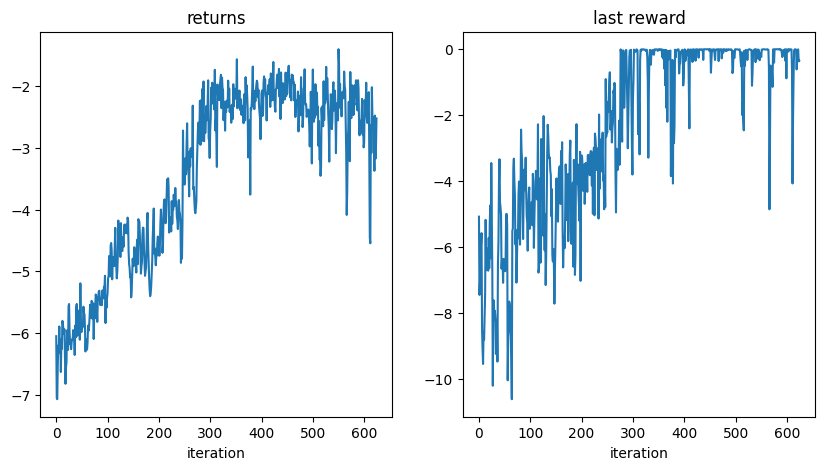

In [18]:
import tqdm
from collections import defaultdict

optim = torch.optim.Adam(policy.parameters(), lr=2e-3)
batch_size = 32
pbar = tqdm.tqdm(range(20_000 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 20_000)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(100, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()